In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/test.csv
/kaggle/input/contradictory-my-dear-watson/train.csv


In [2]:
df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


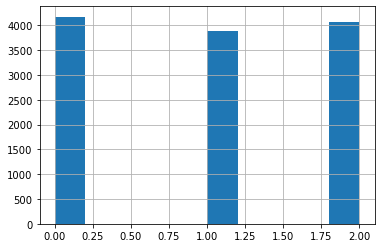

In [3]:
df['label'].hist() # Approximately uniformly distributed

In [4]:
!pip install googletrans

     |████████████████████████████████| 55 kB 231 kB/s 
     |████████████████████████████████| 42 kB 360 kB/s 
     |████████████████████████████████| 953 kB 535 kB/s 
     |████████████████████████████████| 65 kB 1.5 MB/s 
     |████████████████████████████████| 53 kB 1.0 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=747488774ee27196ca9cd609731ebe274072e301bbdf7641929960576753d363
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:


import tensorflow_hub as hub

embedding_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'

#model = tf.keras.Sequential()

embedding_layer = hub.KerasLayer(embedding_url, trainable=True)
premises = tf.keras.layers.Input(shape=(), name="Input1", dtype=tf.string)
conclusion = tf.keras.layers.Input(shape=(), name="Input2", dtype=tf.string)
x1 = embedding_layer(premises)
x2 = embedding_layer(conclusion) 
subtracted = tf.keras.layers.Add()([x1, x2])
subtracted = tf.keras.layers.BatchNormalization()(subtracted)
subtracted = tf.keras.layers.Dropout(0.5)(subtracted)
output = tf.keras.layers.Dense(512, activation='relu')(subtracted)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dense(128, activation='relu')(subtracted)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dense(3)(output)

model = tf.keras.Model(inputs=[premises, conclusion], outputs=output)
optimizer = tf.keras.optimizers.Adamax()
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

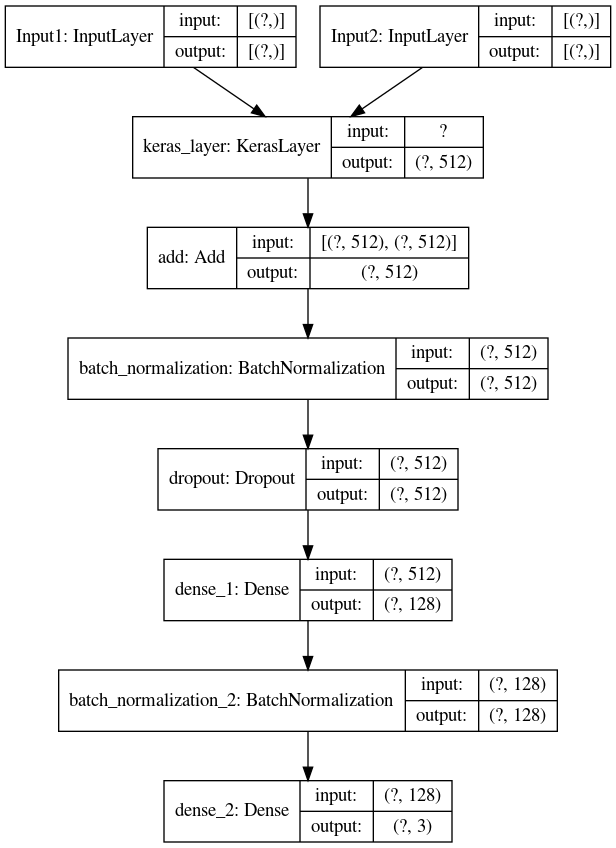

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
from random import randint
from googletrans import Translator
translator = Translator()

def generate_batch(batch_size=32):
    premise_tensor = []
    conclusion_tensor = []
    label_tensor = []
    
    for i in range(batch_size):
        index = randint(0, len(df) - 1)
        premise_tensor.append(translator.translate(df.iloc[index, :].premise).text)
        conclusion_tensor.append(translator.translate(df.iloc[index, :].hypothesis).text)
        label_tensor.append(df.iloc[index, :].label)
    
    return tf.data.Dataset.from_tensor_slices(({"Input1": premise_tensor, "Input2": conclusion_tensor}, label_tensor)).batch(batch_size)

In [8]:
test = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


Cannot use checkpoints because the fit method is called multiple times

In [9]:
epochs = 5
batch_size = 32
steps_per_epoch = len(df) // batch_size
steps = int(steps_per_epoch * epochs // 6)

best_loss = 1000

for i in range(steps):
    for X, y in generate_batch(batch_size).take(1):
        #model.fit(X, y)
        model.train_on_batch(X, y)
        
        if i % 5 == 0:
            for X_val, y_val in generate_batch(batch_size).take(1):
                val_loss = model.evaluate(X_val, y_val)
                if val_loss < best_loss:
                    model.save('./model_weights')
                    best_loss = val_loss

1/1 [==============================] - 0s 6ms/step - loss: 1.1114


In [10]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [11]:
model = tf.keras.models.load_model('./model_weights')

In [12]:
test_premises = test.loc[:, 'premise']
test_conclusion = test.loc[:, 'hypothesis']
test_ids = test.loc[:, 'id']
preds = np.argmax(model.predict({"Input1" : test_premises, "Input2": test_conclusion}), axis=-1)
submission_df = pd.DataFrame({'id' : test_ids, 'prediction' : preds})
submission_df.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,2
3,58518c10ba,2
4,c32b0d16df,2


In [13]:
submission_df.to_csv('submission.csv', index=False)